In [0]:
%python
# Install necessary libraries
%pip install geopandas
%pip install folium


# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime, timedelta
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report
from sklearn.preprocessing import LabelEncoder
import geopandas as gpd
from shapely.geometry import Point
import folium
from folium.plugins import HeatMap
import warnings
warnings.filterwarnings('ignore')

%matplotlib inline

Note: you may need to restart the kernel using %restart_python or dbutils.library.restartPython() to use updated packages.
Note: you may need to restart the kernel using %restart_python or dbutils.library.restartPython() to use updated packages.


In [0]:
%python
# Load the LA Crime dataset (2020-present) from data.lacity.org
# Note: This assumes you've downloaded the data or have API access
# For this example, we'll use a sample file path - replace with your actual path

def load_crime_data():
    try:
        # Try to load from local file first
        import pandas as pd
        crime_df = pd.read_csv('/Volumes/workspace/default/crimedataset/Crime_Data_from_2020_to_Present.csv')
        # Filter for 2020 to present
        crime_df['DATE OCC'] = pd.to_datetime(crime_df['DATE OCC'])
        crime_df = crime_df[crime_df['DATE OCC'] >= '2020-01-01']
        
        # Save a local copy
        crime_df.to_csv('LA_Crime_Data_2020_to_Present.csv', index=False)
    
    except Exception as e:
        print(f"An error occurred: {e}")
        return None
    
    return crime_df

crime_data = load_crime_data()
if crime_data is not None:
    print(f"Dataset loaded with {len(crime_data)} records")
else:
    print("Failed to load dataset")

Dataset loaded with 1005091 records


In [0]:
# Create metadata dictionary
metadata = {
    'dataset_name': 'Los Angeles Crime Data 2020-Present',
    'source': 'data.lacity.org',
    'last_updated': datetime.now().strftime('%Y-%m-%d'),
    'columns': [],
    'data_quality_issues': []
}

# Populate column metadata
for col in crime_data.columns:
    col_meta = {
        'name': col,
        'dtype': str(crime_data[col].dtype),
        'unique_values': int(crime_data[col].nunique()),
        'null_values': int(crime_data[col].isnull().sum()),
        'description': ''
    }
    metadata['columns'].append(col_meta)
    
    # Record data quality issues
    if crime_data[col].isnull().sum() > 0:
        metadata['data_quality_issues'].append(
            f"Column {col} has {int(crime_data[col].isnull().sum())} null values"
        )

# Display metadata summary
print("=== Dataset Metadata ===")
print(f"Records: {len(crime_data)}")
print(f"Time Range: {crime_data['DATE OCC'].min()} to {crime_data['DATE OCC'].max()}")
print(f"Columns: {len(crime_data.columns)}")
print("\n=== Data Quality Issues ===")
for issue in metadata['data_quality_issues']:
    print(f"- {issue}")

# Save metadata to JSON
import json
with open('crime_data_metadata.json', 'w') as f:
    json.dump(metadata, f, indent=4)

=== Dataset Metadata ===
Records: 1005091
Time Range: 2020-01-01 00:00:00 to 2025-04-29 00:00:00
Columns: 28

=== Data Quality Issues ===
- Column Mocodes has 151705 null values
- Column Vict Sex has 144729 null values
- Column Vict Descent has 144741 null values
- Column Premis Cd has 16 null values
- Column Premis Desc has 588 null values
- Column Weapon Used Cd has 677841 null values
- Column Weapon Desc has 677841 null values
- Column Status has 1 null values
- Column Crm Cd 1 has 11 null values
- Column Crm Cd 2 has 935934 null values
- Column Crm Cd 3 has 1002777 null values
- Column Crm Cd 4 has 1005027 null values
- Column Cross Street has 850854 null values


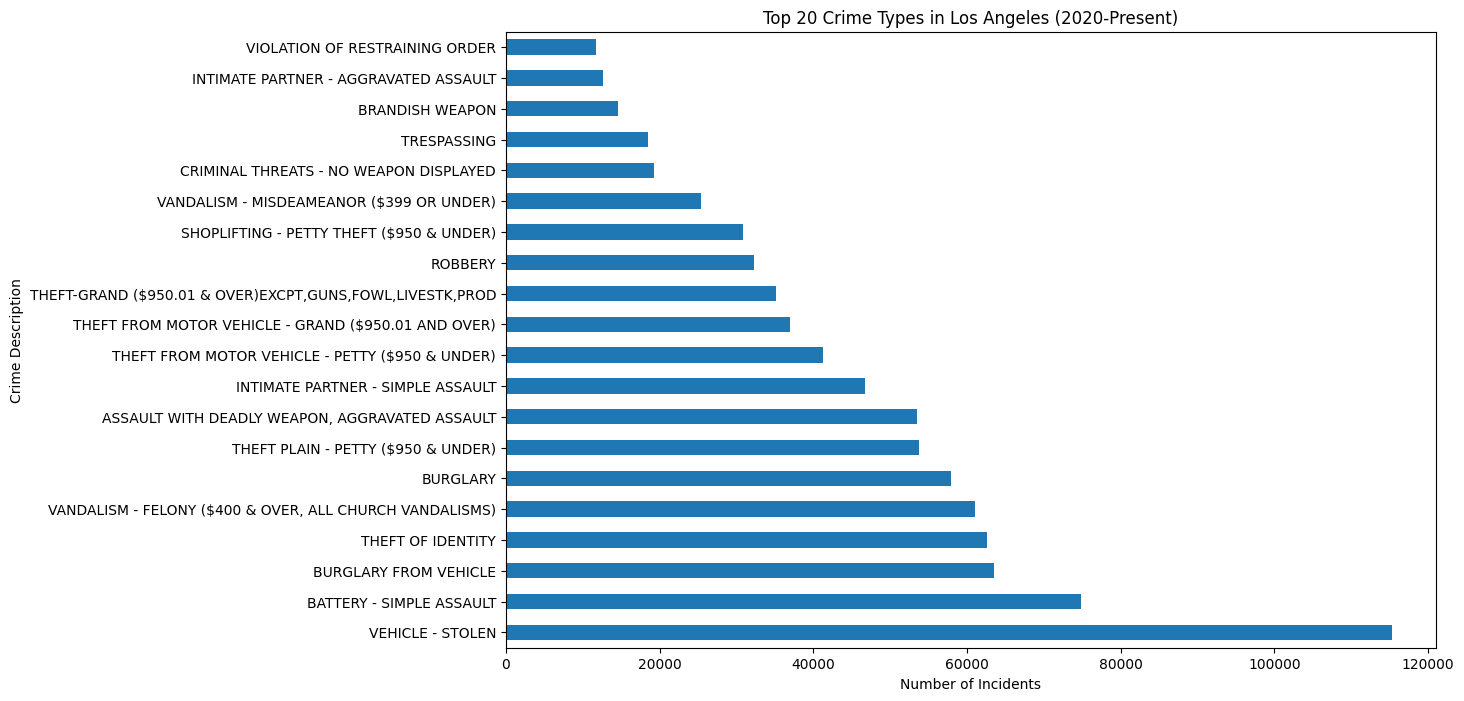

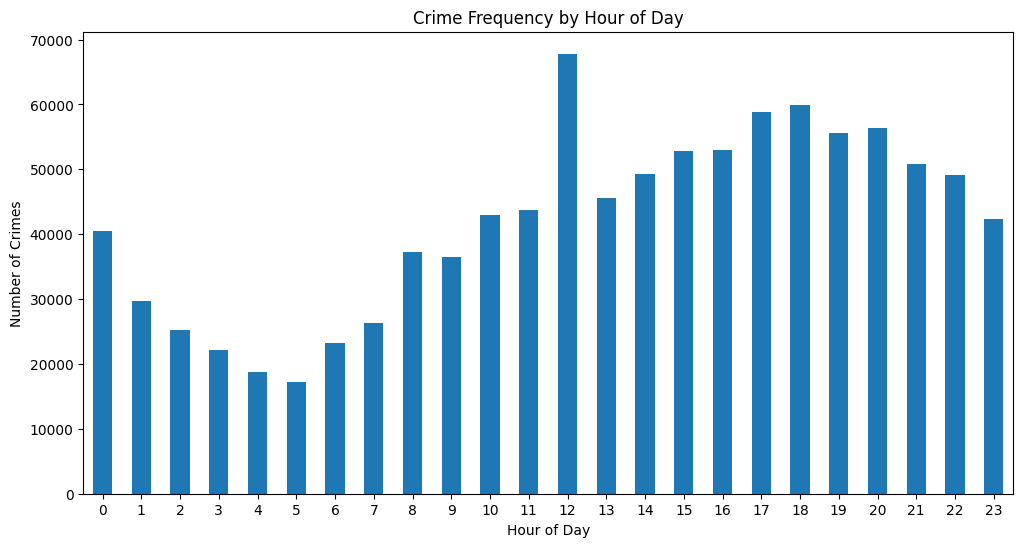

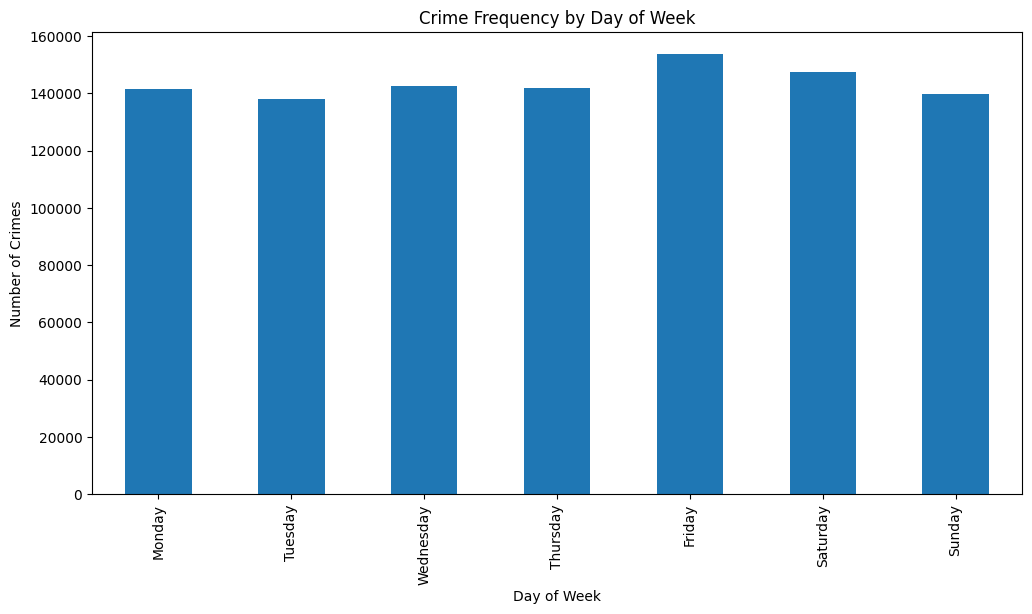

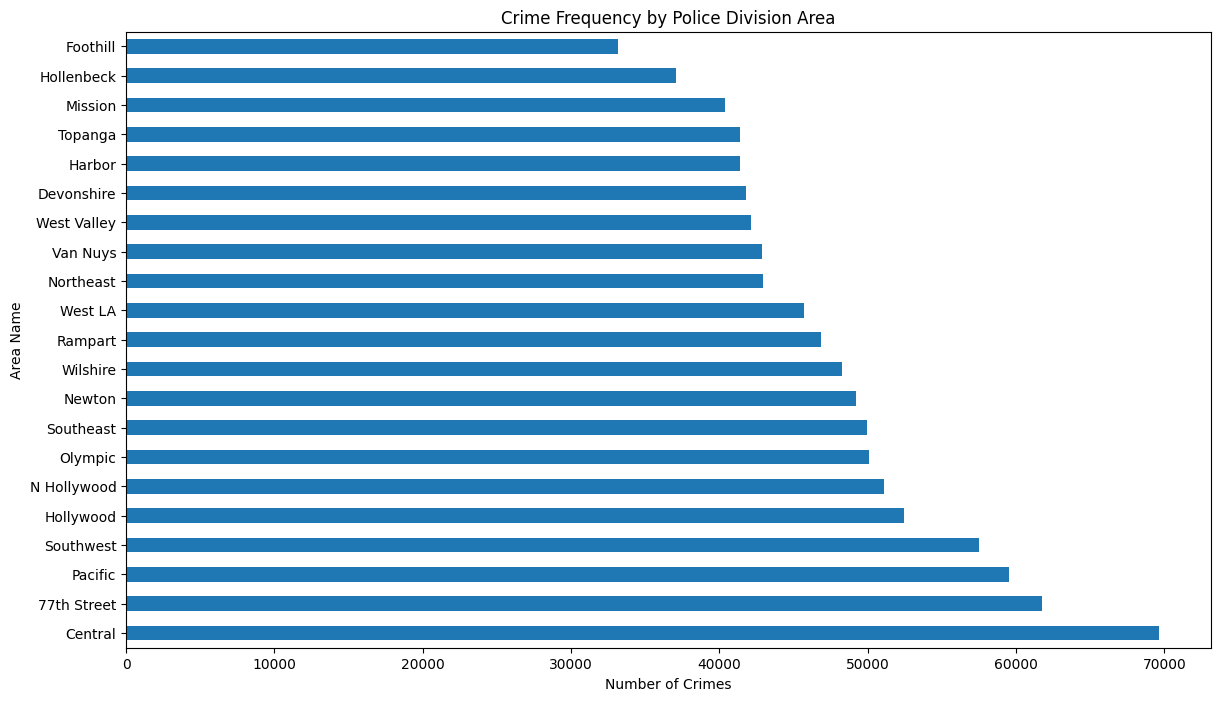

In [0]:
# Basic data cleaning
crime_data_clean = crime_data.copy()

# Handle missing values
crime_data_clean['Weapon Used Cd'] = crime_data_clean['Weapon Used Cd'].fillna('None')
crime_data_clean['Weapon Desc'] = crime_data_clean['Weapon Desc'].fillna('No Weapon')
crime_data_clean['Vict Sex'] = crime_data_clean['Vict Sex'].fillna('Unknown')

# Convert date to datetime and extract features
crime_data_clean['DATE OCC'] = pd.to_datetime(crime_data_clean['DATE OCC'])
crime_data_clean['year'] = crime_data_clean['DATE OCC'].dt.year
crime_data_clean['month'] = crime_data_clean['DATE OCC'].dt.month
crime_data_clean['day'] = crime_data_clean['DATE OCC'].dt.day
crime_data_clean['hour'] = crime_data_clean['TIME OCC'].astype(str).str.zfill(4).str[:2].astype(int)
crime_data_clean['day_of_week'] = crime_data_clean['DATE OCC'].dt.day_name()

# Top crime categories
plt.figure(figsize=(12, 8))
crime_data_clean['Crm Cd Desc'].value_counts().head(20).plot(kind='barh')
plt.title('Top 20 Crime Types in Los Angeles (2020-Present)')
plt.xlabel('Number of Incidents')
plt.ylabel('Crime Description')
plt.show()

# Crime by hour of day
plt.figure(figsize=(12, 6))
crime_data_clean['hour'].value_counts().sort_index().plot(kind='bar')
plt.title('Crime Frequency by Hour of Day')
plt.xlabel('Hour of Day')
plt.ylabel('Number of Crimes')
plt.xticks(rotation=0)
plt.show()

# Crime by day of week
plt.figure(figsize=(12, 6))
crime_data_clean['day_of_week'].value_counts().reindex([
    'Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday'
]).plot(kind='bar')
plt.title('Crime Frequency by Day of Week')
plt.xlabel('Day of Week')
plt.ylabel('Number of Crimes')
plt.show()

# Crime by area
plt.figure(figsize=(14, 8))
crime_data_clean['AREA NAME'].value_counts().plot(kind='barh')
plt.title('Crime Frequency by Police Division Area')
plt.xlabel('Number of Crimes')
plt.ylabel('Area Name')
plt.show()

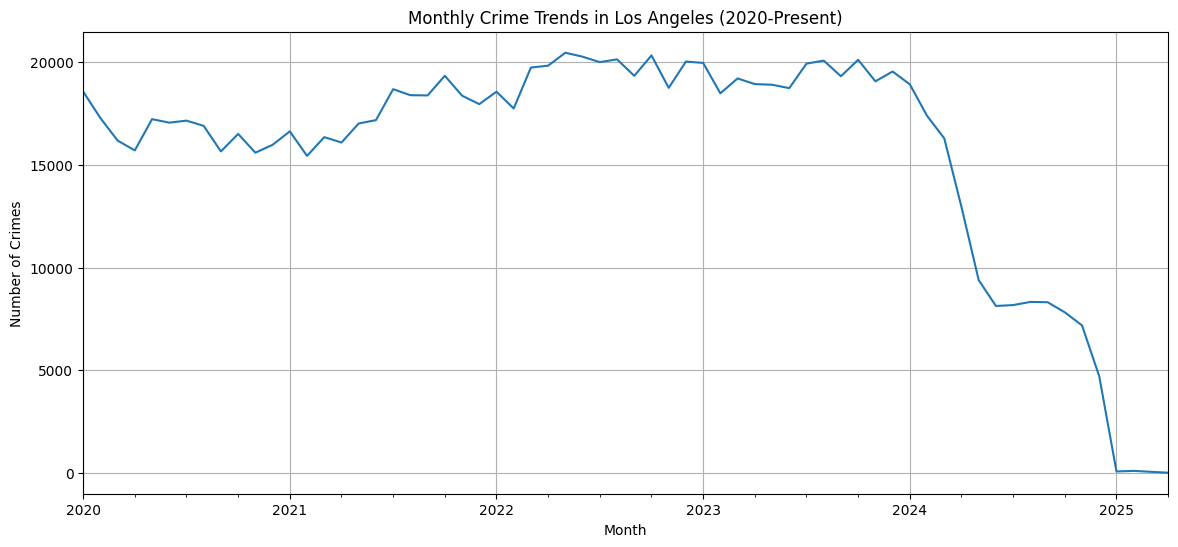

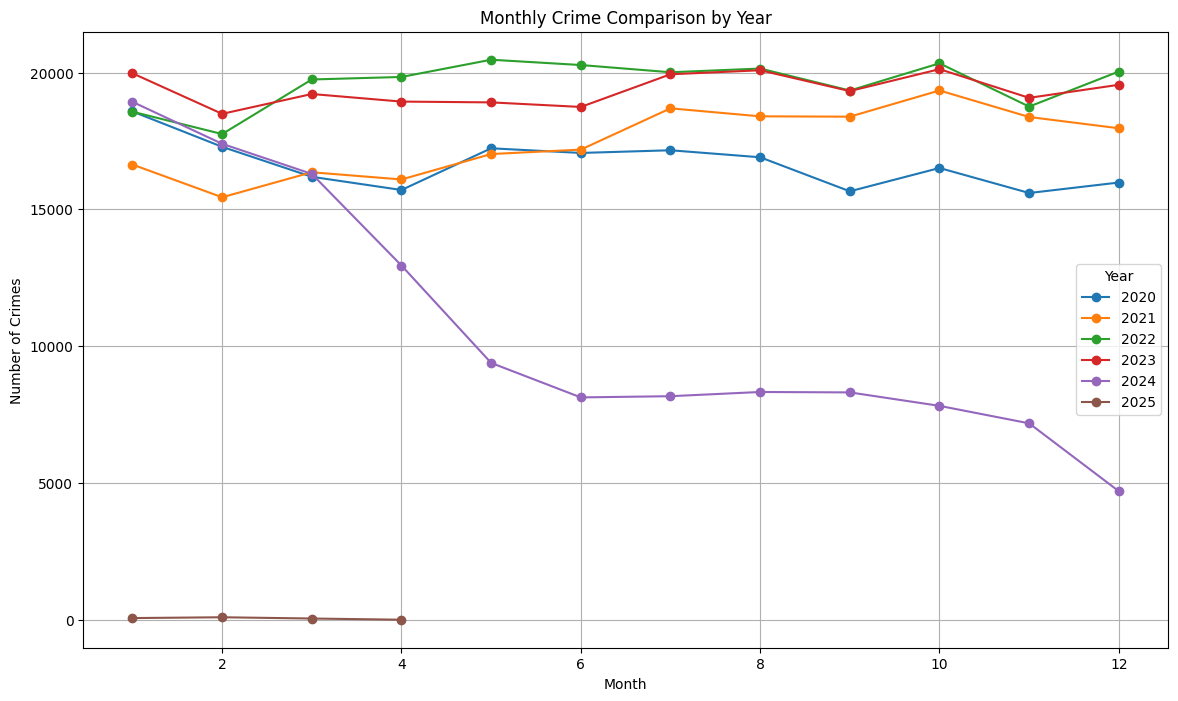

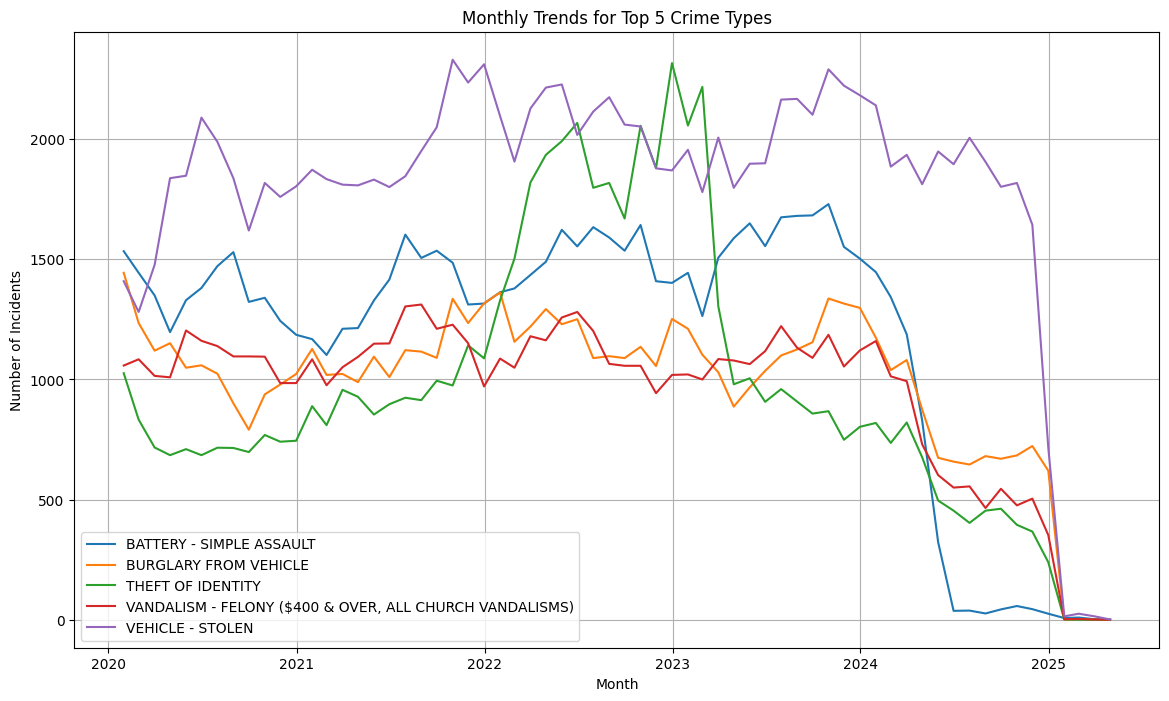

In [0]:
# Monthly crime trends
monthly_trends = crime_data_clean.resample('M', on='DATE OCC').size()

plt.figure(figsize=(14, 6))
monthly_trends.plot()
plt.title('Monthly Crime Trends in Los Angeles (2020-Present)')
plt.xlabel('Month')
plt.ylabel('Number of Crimes')
plt.grid(True)
plt.show()

# Year-over-year comparison
yearly_comparison = crime_data_clean.groupby(['year', 'month']).size().unstack(level=0)

plt.figure(figsize=(14, 8))
for year in yearly_comparison.columns:
    plt.plot(yearly_comparison.index, yearly_comparison[year], label=year, marker='o')
plt.title('Monthly Crime Comparison by Year')
plt.xlabel('Month')
plt.ylabel('Number of Crimes')
plt.legend(title='Year')
plt.grid(True)
plt.show()

# Crime type trends
top_crimes = crime_data_clean['Crm Cd Desc'].value_counts().head(5).index.tolist()
crime_type_trends = crime_data_clean[crime_data_clean['Crm Cd Desc'].isin(top_crimes)]
crime_type_trends = crime_type_trends.groupby(['DATE OCC', 'Crm Cd Desc']).size().unstack().resample('M').sum()

plt.figure(figsize=(14, 8))
for crime in crime_type_trends.columns:
    plt.plot(crime_type_trends.index, crime_type_trends[crime], label=crime)
plt.title('Monthly Trends for Top 5 Crime Types')
plt.xlabel('Month')
plt.ylabel('Number of Incidents')
plt.legend()
plt.grid(True)
plt.show()

# Geographic heatmap
# Create a sample of the data for visualization (full dataset may be too large)
sample_data = crime_data_clean.sample(10000, random_state=42)

# Create base map
la_map = folium.Map(location=[34.0522, -118.2437], zoom_start=11)

# Add heatmap
heat_data = [[row['LAT'], row['LON']] for index, row in sample_data.dropna(subset=['LAT', 'LON']).iterrows()]
HeatMap(heat_data, radius=10).add_to(la_map)

# Display the map
la_map

                                                          precision    recall  f1-score   support

                                                   ARSON       0.00      0.00      0.00        13
            ASSAULT WITH DEADLY WEAPON ON POLICE OFFICER       0.00      0.00      0.00         9
          ASSAULT WITH DEADLY WEAPON, AGGRAVATED ASSAULT       0.16      0.21      0.18       279
                                       ATTEMPTED ROBBERY       0.00      0.00      0.00        18
                                BATTERY - SIMPLE ASSAULT       0.11      0.19      0.14       339
                                BATTERY ON A FIREFIGHTER       0.00      0.00      0.00         1
                                 BATTERY POLICE (SIMPLE)       0.00      0.00      0.00        11
                             BATTERY WITH SEXUAL CONTACT       0.00      0.00      0.00        16
                                           BIKE - STOLEN       0.05      0.03      0.04        33
                   

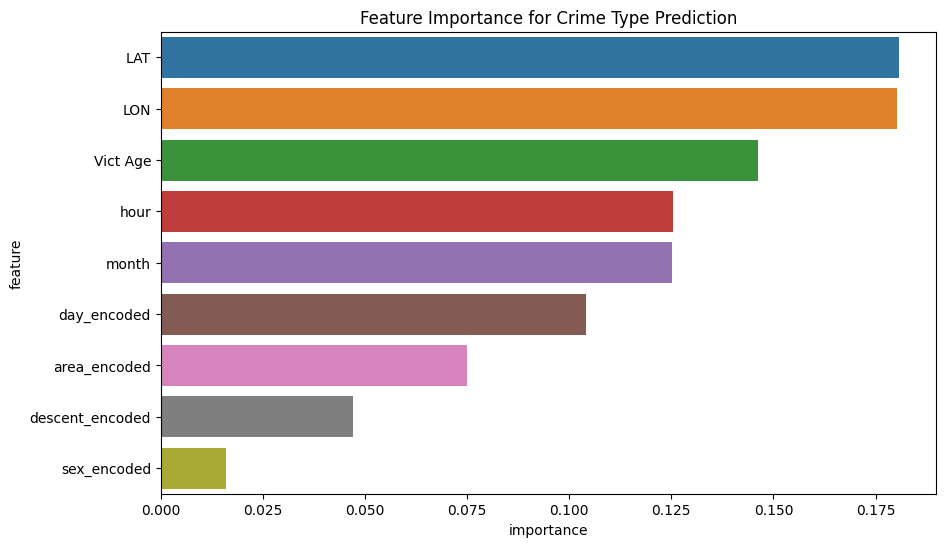

In [0]:
%python
# Prepare data for predictive modeling
# We'll predict the crime type based on location, time, and other features

# Select relevant features and sample to avoid memory issues
model_data = crime_data_clean[[
    'Crm Cd Desc', 'AREA NAME', 'day_of_week', 'hour', 'month', 
    'Vict Age', 'Vict Sex', 'Vict Descent', 'LAT', 'LON'
]].dropna()

# Sample a smaller subset for modeling to avoid MemoryError (e.g., 20,000 rows)
if len(model_data) > 20000:
    model_data = model_data.sample(20000, random_state=42)

# Encode categorical variables
le_crime = LabelEncoder()
model_data['crime_encoded'] = le_crime.fit_transform(model_data['Crm Cd Desc'])

le_area = LabelEncoder()
model_data['area_encoded'] = le_area.fit_transform(model_data['AREA NAME'])

le_day = LabelEncoder()
model_data['day_encoded'] = le_day.fit_transform(model_data['day_of_week'])

le_sex = LabelEncoder()
model_data['sex_encoded'] = le_sex.fit_transform(model_data['Vict Sex'])

le_descent = LabelEncoder()
model_data['descent_encoded'] = le_descent.fit_transform(model_data['Vict Descent'])

# Prepare features and target
X = model_data[['area_encoded', 'day_encoded', 'hour', 'month', 
               'Vict Age', 'sex_encoded', 'descent_encoded', 'LAT', 'LON']]
y = model_data['crime_encoded']

# Split data
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

# Train Random Forest model with fewer trees to save memory
rf_model = RandomForestClassifier(n_estimators=50, random_state=42, n_jobs=-1)
rf_model.fit(X_train, y_train)

# Evaluate model
y_pred = rf_model.predict(X_test)
print(classification_report(
    y_test, y_pred, target_names=le_crime.classes_, labels=np.unique(y_test)
))

# Feature importance
feature_importance = pd.DataFrame({
    'feature': X.columns,
    'importance': rf_model.feature_importances_
}).sort_values('importance', ascending=False)

plt.figure(figsize=(10, 6))
sns.barplot(x='importance', y='feature', data=feature_importance)
plt.title('Feature Importance for Crime Type Prediction')
plt.show()

=== Next Crime Prediction Example ===
Area: Hollywood
Day: Friday
Hour: 20 (8 PM)
Month: 7 (July)

Top 5 Predicted Crimes with Probabilities:
                   Crime Type  Probability
0    BATTERY - SIMPLE ASSAULT         0.30
1  KIDNAPPING - GRAND ATTEMPT         0.20
2       BURGLARY FROM VEHICLE         0.18
3                    BURGLARY         0.04
4            RESISTING ARREST         0.04


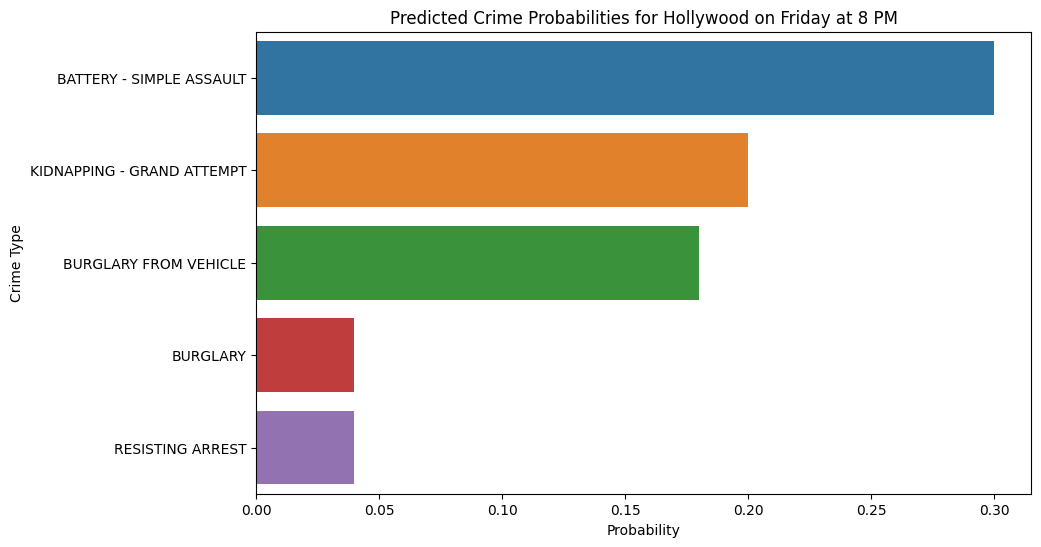

In [0]:
# Function to predict the next likely crime in a given area and time
def predict_next_crime(area_name, day_of_week, hour, month, victim_age=30, 
                      victim_sex='F', victim_descent='B', lat=34.0522, lon=-118.2437):
    # Encode inputs
    try:
        area_encoded = le_area.transform([area_name])[0]
        day_encoded = le_day.transform([day_of_week])[0]
        sex_encoded = le_sex.transform([victim_sex])[0]
        descent_encoded = le_descent.transform([victim_descent])[0]
    except ValueError as e:
        print(f"Error in encoding: {e}")
        return None
    
    # Create feature vector
    features = np.array([[
        area_encoded, day_encoded, hour, month, 
        victim_age, sex_encoded, descent_encoded, lat, lon
    ]])
    
    # Predict probabilities
    probas = rf_model.predict_proba(features)[0]
    
    # Get top 5 predictions
    top5_idx = np.argsort(probas)[-5:][::-1]
    top5_crimes = le_crime.inverse_transform(top5_idx)
    top5_probs = probas[top5_idx]
    
    # Create prediction dataframe
    predictions = pd.DataFrame({
        'Crime Type': top5_crimes,
        'Probability': top5_probs
    })
    
    return predictions

# Example prediction for Hollywood area on Friday night
print("=== Next Crime Prediction Example ===")
print("Area: Hollywood")
print("Day: Friday")
print("Hour: 20 (8 PM)")
print("Month: 7 (July)")

predictions = predict_next_crime(
    area_name='Hollywood',
    day_of_week='Friday',
    hour=20,
    month=7
)

print("\nTop 5 Predicted Crimes with Probabilities:")
print(predictions)

# Visualize prediction
plt.figure(figsize=(10, 6))
sns.barplot(x='Probability', y='Crime Type', data=predictions)
plt.title('Predicted Crime Probabilities for Hollywood on Friday at 8 PM')
plt.show()

In [0]:
# Save the final cleaned dataset and model for future use
crime_data_clean.to_csv('LA_Crime_Data_Clean_2020_Present.csv', index=False)

import joblib
joblib.dump(rf_model, 'crime_prediction_model.pkl')

---------------------------------------------------------------------------
OSError                                   Traceback (most recent call last)
File /databricks/python/lib/python3.11/site-packages/joblib/numpy_pickle.py:553, in dump(value, filename, compress, protocol, cache_size)
    552     with open(filename, 'wb') as f:
--> 553         NumpyPickler(f, protocol=protocol).dump(value)
    554 else:

File /usr/lib/python3.11/pickle.py:487, in _Pickler.dump(self, obj)
    486     self.framer.start_framing()
--> 487 self.save(obj)
    488 self.write(STOP)

File /databricks/python/lib/python3.11/site-packages/joblib/numpy_pickle.py:355, in NumpyPickler.save(self, obj)
    353     return
--> 355 return Pickler.save(self, obj)

File /usr/lib/python3.11/pickle.py:603, in _Pickler.save(self, obj, save_persistent_id)
    602 # Save the reduce() output and finally memoize the object
--> 603 self.save_reduce(obj=obj, *rv)

File /usr/lib/python3.11/pickle.py:717, in _Pickler.save_reduce(s